# Importing Libraries

In [1]:
import numpy as np
import cv2 as cv
from data import *
from GMM_Class import GMM
from helpers import *
import matplotlib.pyplot as plt
import pandas as pd
import time
from sklearn.metrics import PrecisionRecallDisplay, roc_curve,auc

# Loading the data

- Divide the puzzle images into training (70%), validation (15%) and test (15%) sets, which you will use for training and analysis in the tasks b

In [2]:
path_to_images = "puzzle/images/"
path_to_masks = "puzzle/masks/"
images,masks = load_data(path_to_images,path_to_masks)
train_x,train_y,validation_x,validation_y,test_x,test_y = split_data(images,masks,0.7,0.15,0.15)

In [3]:
print(f"There are {len(train_x)} training images.")
print(f"There are {len(validation_x)} validation images.")
print(f"There are {len(test_x)} test images.")

There are 34 training images.
There are 7 validation images.
There are 7 test images.


# Gaussian Mixture Model

## Getting the class Priors

In [4]:
foreground_prior, background_prior = get_priors(train_y)
print(f"The foreground prior is: {foreground_prior}")
print(f"The background prior is: {background_prior}")

The foreground prior is: 0.24708123300589768
The background prior is: 0.7529187669941023


## 1) RGB pixel values as the feature set

In [5]:
foreground_x,background_x = get_features(train_x,train_y)

### Creating Background and Foreground GMM

In [6]:
Foreground_GMM = GMM(n_components =3,max_iterations=20,tolerance=1e-15)
Foreground_GMM.fit(foreground_x)

In [7]:
Background_GMM = GMM(n_components =3,max_iterations=20,tolerance=1e-15)
Background_GMM.fit(background_x)

### Getting the Validation results

In [8]:
valid_results = predict_output(Foreground_GMM,Background_GMM,foreground_prior,background_prior,validation_x)

In [9]:
rgb_iou, rgb_dice = metrics_eval(valid_results,validation_y,"Validation")

The Validation IOU is: 0.891 %
The Validation DICE is: 0.936 %


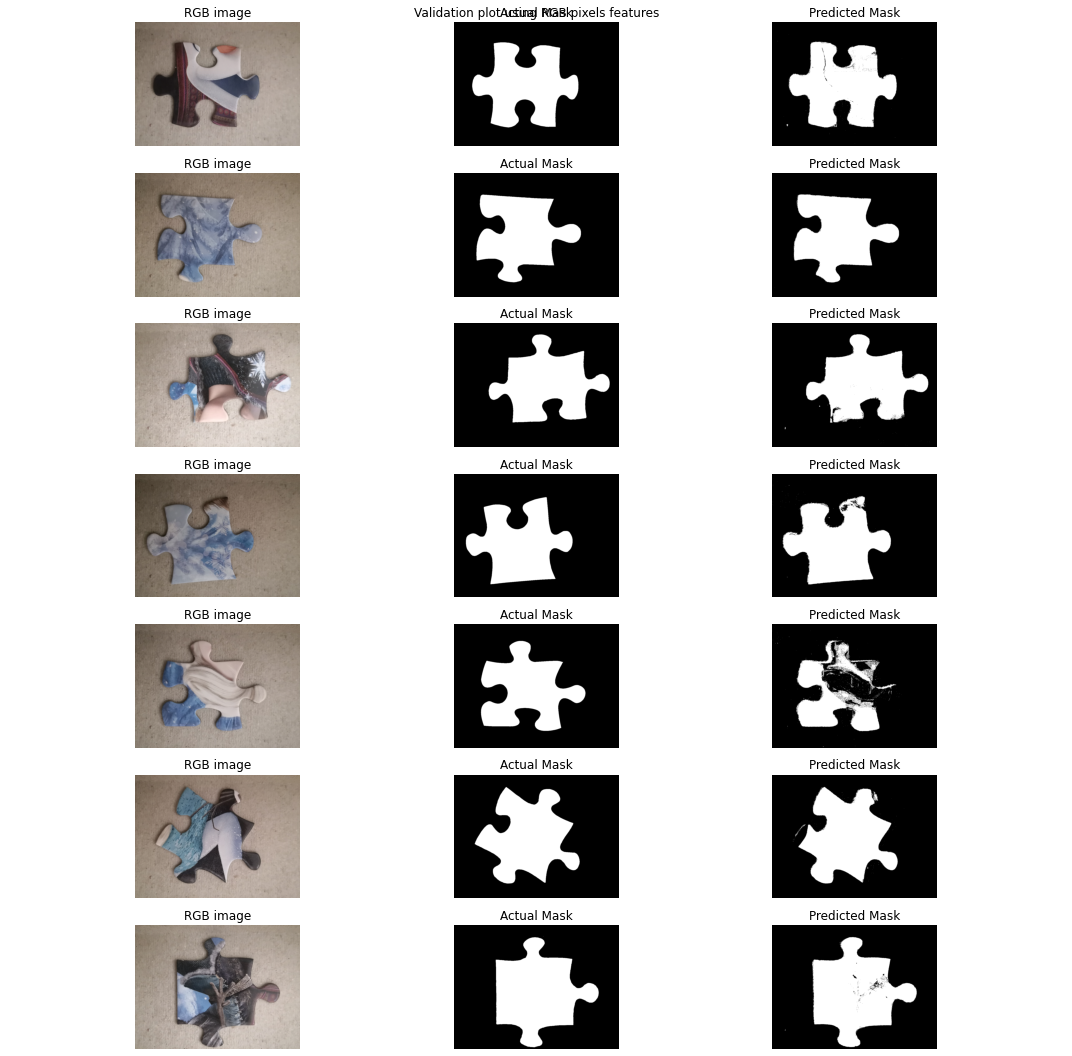

In [10]:
plot(valid_results,validation_y,validation_x,"Validation","RGB pixels")

## 2) RGB pixel values + Difference of Gaussians

In [11]:
foreground_x_dog,background_x_dog = get_features(train_x,train_y,DOG=True)
validation_x_dog = get_features_extended(validation_x,DOG= True)

### Creating Background and Foreground GMM

In [12]:
Foreground_GMM_dog = GMM(n_components =3,max_iterations=20,tolerance=1e-15)
Foreground_GMM_dog.fit(foreground_x_dog)


Background_GMM_dog = GMM(n_components =3,max_iterations=20,tolerance=1e-15)
Background_GMM_dog.fit(background_x_dog)

### Getting the Validation results

In [13]:
valid_results_dog = predict_output(Foreground_GMM_dog,Background_GMM_dog,foreground_prior,background_prior,validation_x_dog)

In [14]:
dog_iou, dog_dice = metrics_eval(valid_results_dog,validation_y,"Validation")

The Validation IOU is: 0.897 %
The Validation DICE is: 0.94 %


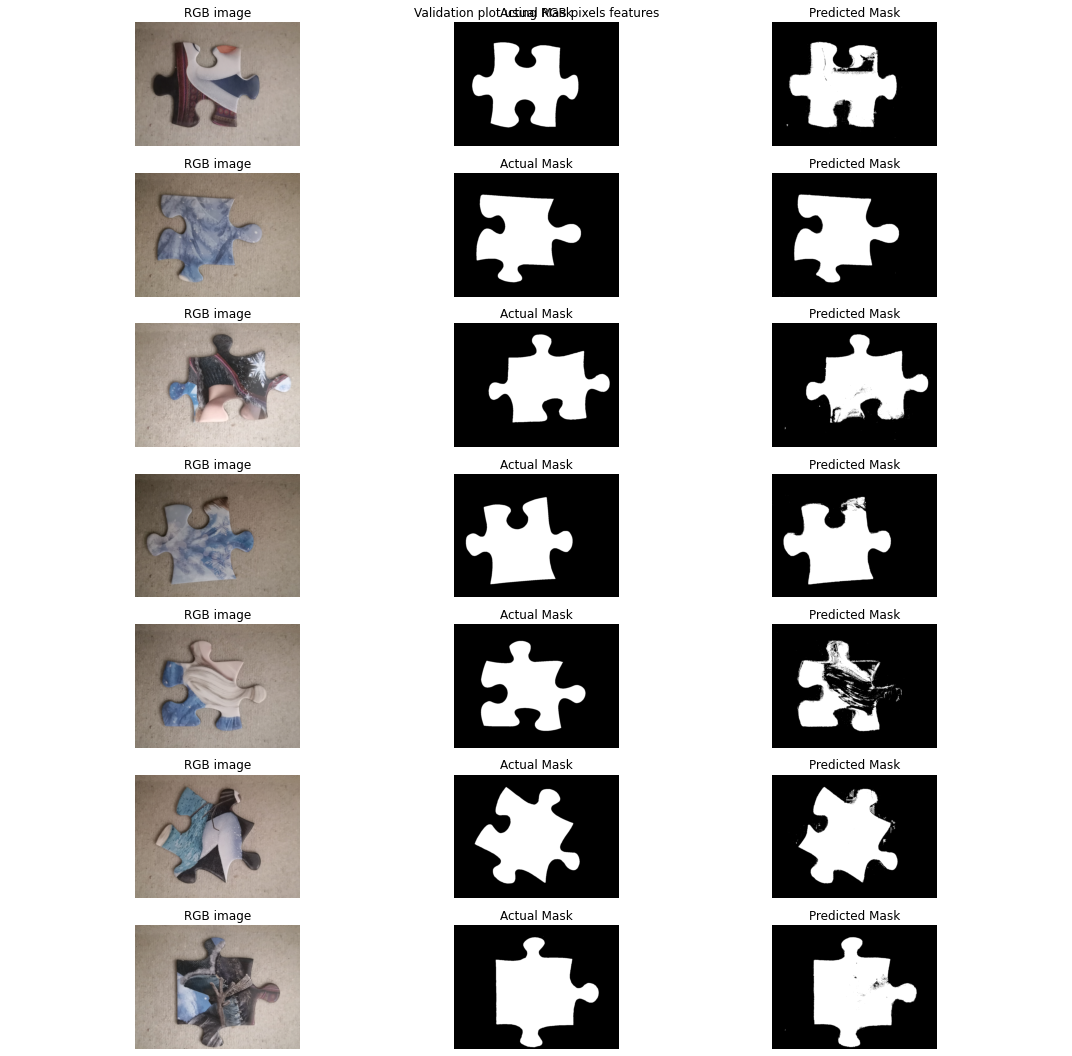

In [15]:
plot(valid_results_dog,validation_y,validation_x,"Validation","RGB pixels")

## 3) RGB pixel values + Texton Values

In [16]:
foreground_x_texton,background_x_texton = get_features(train_x,train_y,Texton=True)
validation_x_texton = get_features_extended(validation_x,Texton= True)

### Creating Background and Foreground GMM

In [17]:
Foreground_GMM_texton = GMM(n_components =3,max_iterations=20,tolerance=1e-15)
Foreground_GMM_texton.fit(foreground_x_texton)


Background_GMM_texton = GMM(n_components =3,max_iterations=20,tolerance=1e-15)
Background_GMM_texton.fit(background_x_texton)

### Getting the Validation results

In [18]:
valid_results_texton = predict_output(Foreground_GMM_texton,Background_GMM_texton,foreground_prior,background_prior,validation_x_texton)

In [19]:
texton_iou, texton_dice = metrics_eval(valid_results_texton,validation_y,"Validation")

The Validation IOU is: 0.891 %
The Validation DICE is: 0.937 %


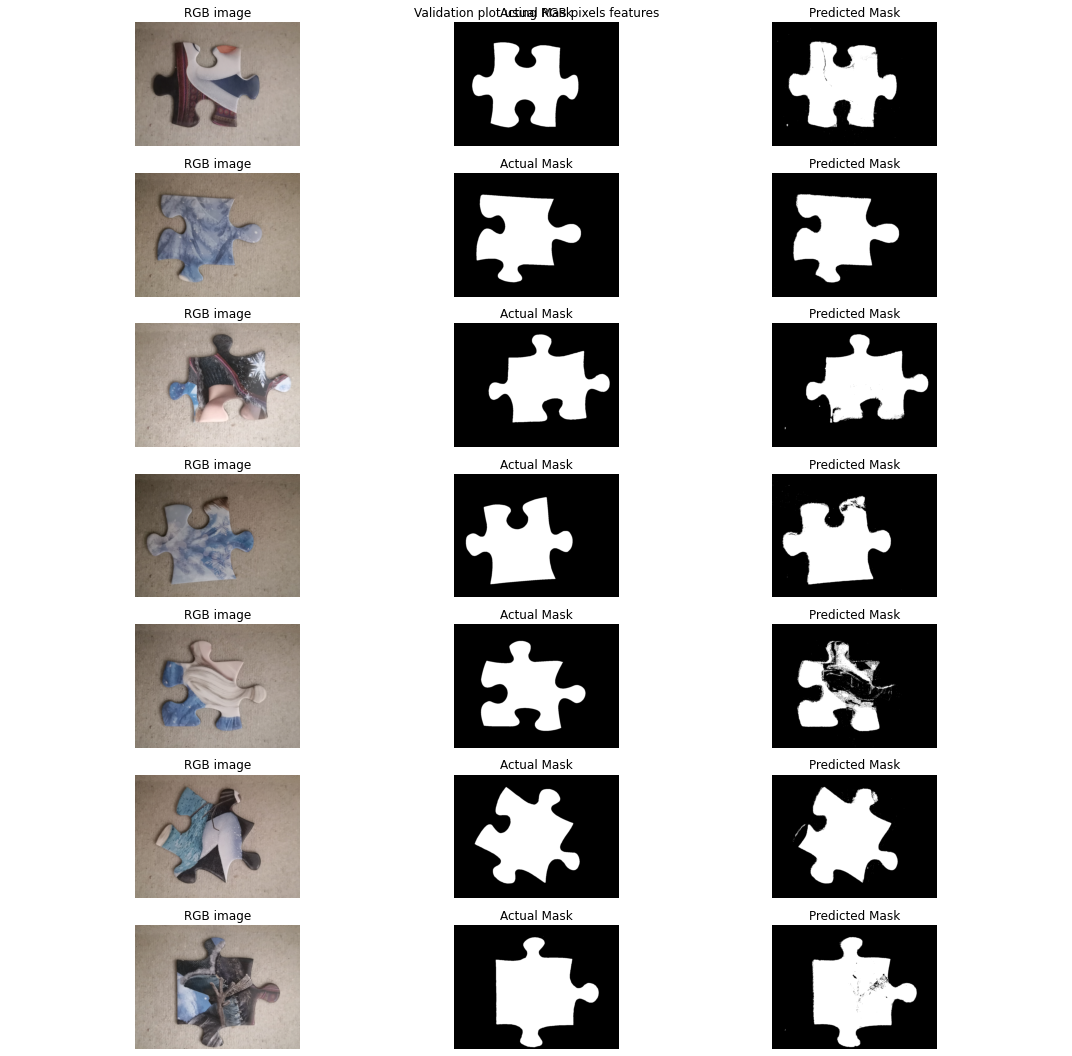

In [20]:
plot(valid_results_texton,validation_y,validation_x,"Validation","RGB pixels")


## Choosing the best feature set

In [21]:
res_df = pd.DataFrame(index = ["RGB","RGB + DOG","RGB + Texton"])
res_df['IOU'] = [rgb_iou,dog_iou,texton_iou]
res_df['DICE'] = [rgb_dice,dog_dice,texton_dice]
res_df

,IOU,DICE
RGB,0.891,0.936
RGB + DOG,0.897,0.940
RGB + Texton,0.891,0.937


- Since we are trying to segment the images in order to utilise them to solve the puzzle, we are more concerned about the model classifying the background properly since this will ensure we can ascertain the correct shape models and edges etc.
- Consequently, we want a model that is more accurate at predicting the foreground, so we favour the model with the best IOU and DICE score. So we choose the "RGB + DOG" feature set.

### Cleaning up variables

In [22]:
del res_df,foreground_x_texton,background_x_texton,Foreground_GMM_texton,Background_GMM_texton,valid_results_texton,texton_iou, texton_dice, foreground_x_dog,background_x_dog,validation_x_dog,Foreground_GMM_dog,Background_GMM_dog,valid_results_dog,dog_dice, dog_iou,foreground_x,background_x,Foreground_GMM,Background_GMM,rgb_iou,rgb_dice,valid_results

## 6 Fold Cross Validation

In [5]:
Train_X = np.vstack((train_x,validation_x))
Train_Y = np.vstack((train_y,validation_y))

In [6]:
def unpack_dict(results):
    df = pd.DataFrame(columns=list(results[0].keys()))

    for i in results:
        df.loc[-1] = i.values()
        df.index = df.index + 1 
    df = df.sort_index()
    return df


### Using 2 components

In [7]:
two_components = K_Fold_Validation(Train_X,Train_Y,2,K = 6)

In [8]:
two_components_df = unpack_dict(two_components)
two_components_df

,training_time,inference_time,iou,dice
0,3.3391,0.0434,0.896,0.938
1,3.2657,0.0495,0.911,0.952
2,3.2190,0.0501,0.942,0.970
3,3.3303,0.0496,0.825,0.899
4,3.3376,0.0554,0.946,0.972
5,3.3278,0.0530,0.864,0.917


### Using 3 components

In [10]:
three_components = K_Fold_Validation(Train_X,Train_Y,3,K = 6)

In [11]:
three_components_df = unpack_dict(three_components)
three_components_df

,training_time,inference_time,iou,dice
0,4.6696,0.0630,0.893,0.936
1,4.5596,0.0719,0.924,0.959
2,4.5649,0.0732,0.946,0.972
3,4.5843,0.0764,0.821,0.896
4,4.5641,0.0738,0.955,0.977
5,4.4840,0.0711,0.870,0.919


### Using 4 components

In [13]:
four_components = K_Fold_Validation(Train_X,Train_Y,4,K = 6)

In [14]:
four_components_df = unpack_dict(four_components)
four_components_df

,training_time,inference_time,iou,dice
0,5.9868,0.0813,0.890,0.933
1,5.9018,0.1000,0.923,0.958
2,5.9746,0.1002,0.946,0.972
3,6.0231,0.1000,0.847,0.913
4,6.0737,0.1069,0.957,0.978
5,5.9083,0.1031,0.887,0.931


### Using 5 components

In [15]:
five_components = K_Fold_Validation(Train_X,Train_Y,5,K = 6)

In [16]:
five_components_df = unpack_dict(five_components)
five_components_df

,training_time,inference_time,iou,dice
0,7.5587,0.1087,0.889,0.933
1,7.3736,0.1366,0.927,0.960
2,7.1842,0.1209,0.952,0.975
3,7.0941,0.1214,0.860,0.922
4,7.1959,0.1246,0.963,0.981
5,6.5349,0.1243,0.884,0.931


### Summarized 6-fold n_iterations Results

In [17]:
summary = pd.DataFrame(columns = five_components_df.columns)
summary.loc[-1] = np.round(two_components_df.mean().values,4)
summary.index = summary.index + 1 
summary.loc[-1] = np.round(three_components_df.mean().values,4)
summary.index = summary.index + 1
summary.loc[-1] = np.round(four_components_df.mean().values,4)
summary.index = summary.index + 1 
summary.loc[-1] = np.round(five_components_df.mean().values,4)
summary.index = summary.index + 1
summary.insert(loc=0, column='n_components', value=[2,3,4,5])
summary = summary.sort_index()
summary

,n_components,training_time,inference_time,iou,dice
0,5,7.1569,0.1228,0.9125,0.9503
1,4,5.9780,0.0986,0.9083,0.9475
2,3,4.5711,0.0716,0.9015,0.9432
3,2,3.3032,0.0502,0.8973,0.9413


- We can see that using more than 2 components did not provide a greater gain in performance, but did lead to an increase in the training time of the model.
- Consequently, the trade-off between speed and accuracy in this instance is negligible and decided to utilise two components.

### Using 10 max_iterations

In [18]:
ten_max = K_Fold_Validation(Train_X,Train_Y,3,10,K = 6)

In [19]:
ten_max_df = unpack_dict(ten_max)
ten_max_df

,training_time,inference_time,iou,dice
0,2.4270,0.0636,0.847,0.908
1,2.3603,0.0762,0.863,0.925
2,2.4109,0.0829,0.905,0.950
3,2.3905,0.0849,0.769,0.861
4,2.4059,0.0756,0.908,0.952
5,2.3611,0.0775,0.815,0.884


### Using 20 max_iterations

In [20]:
twenty_max = K_Fold_Validation(Train_X,Train_Y,3,20,K = 6)

In [21]:
twenty_max_df = unpack_dict(twenty_max)
twenty_max_df

,training_time,inference_time,iou,dice
0,4.7386,0.0660,0.893,0.936
1,4.6593,0.0756,0.924,0.959
2,4.7347,0.0802,0.946,0.972
3,4.6566,0.0808,0.821,0.896
4,4.7307,0.0812,0.955,0.977
5,4.6886,0.0760,0.870,0.919


### Using 30 max_iterations

In [22]:
thirty_max = K_Fold_Validation(Train_X,Train_Y,3,30,K = 6)

In [23]:
thirty_max_df = unpack_dict(thirty_max)
thirty_max_df

,training_time,inference_time,iou,dice
0,7.1858,0.0622,0.898,0.940
1,6.6384,0.0798,0.925,0.960
2,6.9260,0.0773,0.929,0.963
3,6.7689,0.0755,0.861,0.922
4,6.8805,0.0752,0.951,0.974
5,6.6470,0.0752,0.867,0.911


In [24]:
summary = pd.DataFrame(columns = ten_max_df.columns)
summary.loc[-1] = np.round(ten_max_df.mean().values,4)
summary.index = summary.index + 1 
summary.loc[-1] = np.round(twenty_max_df.mean().values,4)
summary.index = summary.index + 1
summary.loc[-1] = np.round(thirty_max_df.mean().values,4)
summary.index = summary.index + 1 
summary.insert(loc=0, column='max_iterations', value=[10,20,30])
summary = summary.sort_index()
summary

,max_iterations,training_time,inference_time,iou,dice
0,30,6.8411,0.0742,0.9052,0.9450
1,20,4.7014,0.0766,0.9015,0.9432
2,10,2.3926,0.0768,0.8512,0.9133


- 10 iterations underfits the data
- 20 and 30 are extremely similar in terms of performance, but 20 trains shorter, so we use 20 iterations

## Best Model

### Training

In [25]:
foreground_x,background_x = get_features(Train_X,Train_Y,DOG=True)

In [26]:
Foreground_GMM = GMM(n_components=3,max_iterations=20,tolerance=1e-15)
Foreground_GMM.fit(foreground_x)

Background_GMM = GMM(n_components=3,max_iterations=20,tolerance=1e-15)
Background_GMM.fit(background_x)

### Testing

In [27]:
testing_features = get_features_extended(test_x,DOG=True)

In [28]:
test_results = predict_output(Foreground_GMM,Background_GMM,foreground_prior,background_prior,testing_features)

In [29]:
test_iou,test_dice = metrics_eval(test_results,test_y,"Testing")

The Testing IOU is: 0.953 %
The Testing DICE is: 0.976 %


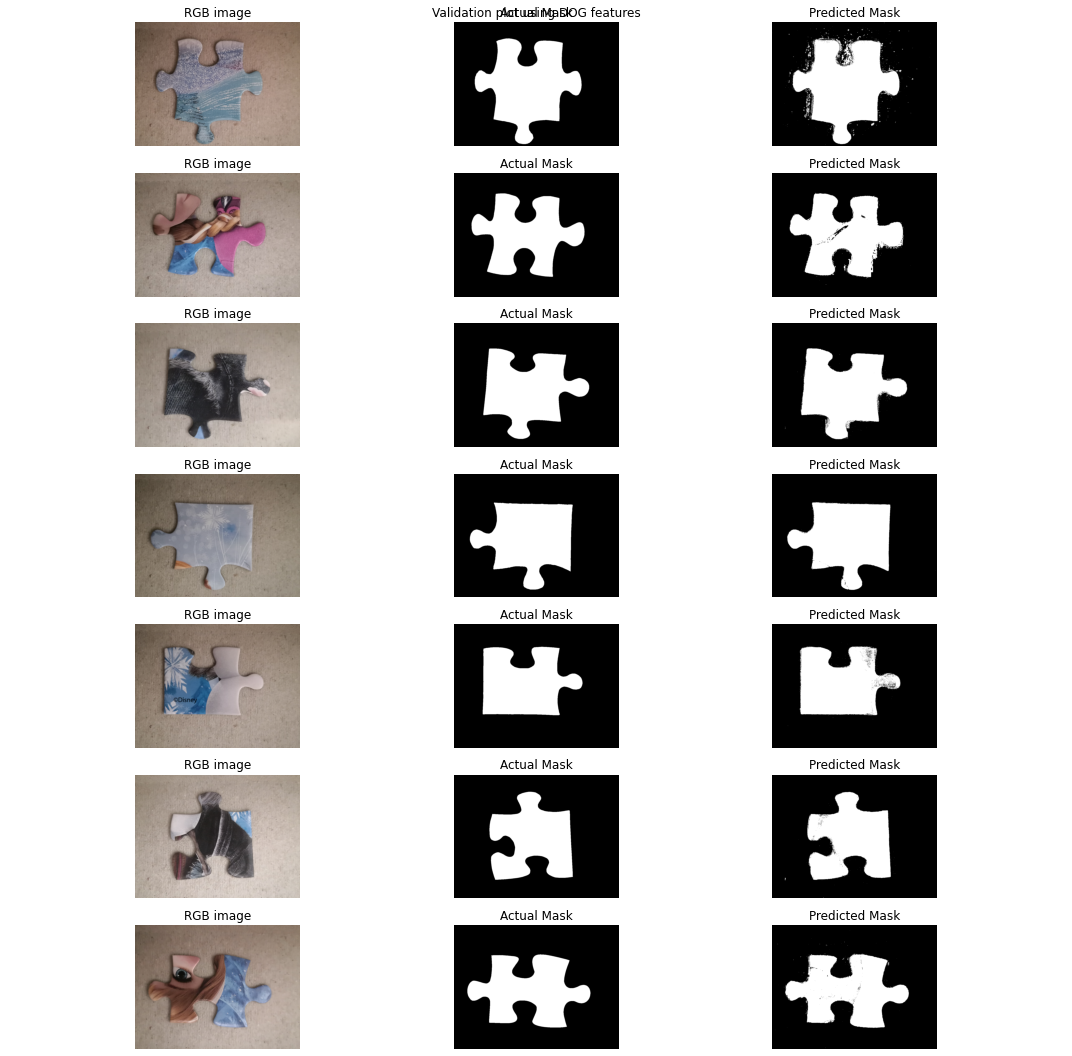

In [30]:
plot(test_results,test_y,test_x,"Validation","DOG")
